In [1]:
import os
# 纯transformer单点预测架构练习
from DataLoader import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
from torch.utils.data import DataLoader
from ProcessData import process_data3

In [2]:
class Transformer(torch.nn.Module):
    # d_model : number of features
    def __init__(self, train_length):
        super(Transformer, self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2, 128, 8)
        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.positional_embedding = torch.nn.Embedding(100, 128)
        # self.decoder_layer = nn.TransformerDecoderLayer(d_model=feature_size, nhead=1, dropout=dropout)
        # self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.decoder = torch.nn.Linear(128, 1)
        self.train_length = train_length
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)==1)).transpose(0,1)
        mask = mask.float().masked_fill(mask==0, float('-inf')).masked_fill(mask==1, float(0.0))
        return mask

    def forward(self, x, src):
        mask = self._generate_square_subsequent_mask(x.shape[1]).cuda()
        # print(src.shape)
        # print(x.shape)
        z = torch.cat((src.unsqueeze(1), x.unsqueeze(1)), dim=1) #[batch, feature, time_step]
        z_embedding = self.input_embedding(z).permute(2,0,1) #[time_step, batch, feature]
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)

        input_embedding = z_embedding+positional_embeddings
        output = self.transformer_encoder(input_embedding, mask)
        # output = self.decoder(tgt=src, memory=output)
        output = self.decoder(output.permute(1,0,2))
        return output


In [3]:
train_length = 30
forcast_window = 7
csv_name = "Palo Alto"

In [4]:
# train_dataset, test_dataset = process_data3(csv_name,train_length, forcast_window)
train_dataset = time_series_decoder_paper2(train_length, forcast_window, 4500)
validation_dataset = time_series_decoder_paper2(train_length, forcast_window,500)
test_dataset = time_series_decoder_paper2(train_length, forcast_window, 1000)

x: 4500*30 fx: 4500*37 train_fx: 4500*30 tar_fx: 4500*7
x: 500*30 fx: 500*37 train_fx: 500*30 tar_fx: 500*7
x: 1000*30 fx: 1000*37 train_fx: 1000*30 tar_fx: 1000*7


In [5]:
criterion = torch.nn.MSELoss()

In [6]:
def Dp(y_pred,y_true,q): # softmax更新
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [7]:
def Rp_num_den(y_preds,y_trues,q): # RPloss
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [40]:
train_data = SensorDataset2(train_dataset, train_length, forcast_window)
test_data = SensorDataset2(test_dataset, train_length, forcast_window)

RuntimeError: Could not infer dtype of slice

In [8]:
# train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
# test_dl = DataLoader(test_data, batch_size=3)
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True) # [batch_size, feature_size]
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [23]:
model = Transformer(train_length).cuda()

In [24]:
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100

In [11]:
def train_epoch(model,train_dl,train_length=30):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,src,tar) in enumerate(train_dl):
        # [batch, time]
        src_in = src[:,:-1]
        src_out = src[:,1:]
        optimizer.zero_grad()
        output = model(x[:,:-1].cuda().float(),src_in.cuda().float())
        # assert 1==0
        # output [batch, time, feature]
        # print('train:',output[0,(train_length-1):(train_length+forcast_window-1)])
        loss = criterion(output.squeeze(-1),src_out.cuda()) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        # print('梯度：', loss.grad)
        optimizer.step()
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        # assert 1== 0
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [25]:
def test_epoch(model,test_dl,train_length=30, forcast_window=7):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,src,tar) in enumerate(test_dl):
            src_in = src[:,:-1]
            src_out = src[:,1:]
            next_input = torch.tensor(src_in)
            all_predictions = []
            for i in range(forcast_window):
                output = model(x[:,:-1].cuda(),next_input.cuda())
                if all_predictions == []:
                    all_predictions = output[:,-1]
                else:
                    all_predictions = torch.cat((all_predictions, output[:,-1].detach()), dim=-1)
                next_input = torch.cat((next_input[:,1:].cuda(), output[:,-1].detach()), dim=-1)

            # print(output.shape) #[batch, seq_len, feature] [128, 48, 1]
            # print('test:', output[0,(train_length-1):(train_length+forcast_window-1)])
            for p,o in zip(all_predictions.cpu().numpy(),tar.numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
    return Rp

In [26]:
train_epoch_loss = []
# eval_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []

    l_t = train_epoch(model,train_dl,train_length)
    train_loss.append(l_t)

    Rp = test_epoch(model,test_dl,train_length, forcast_window)

    if Rp_best > Rp:
        Rp_best = Rp

    train_epoch_loss.append(np.mean(train_loss))

    print("Epoch {}: Train loss: {} \t R_p={}".format(e+1,
                                                             np.mean(train_loss),Rp))

F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1488\3773118932.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_input = torch.tensor(src_in)


Epoch 1: Train loss: 4712.035761284722 	 R_p=0.8128479787756918
Epoch 2: Train loss: 3184.102540581597 	 R_p=0.6583664626914543
Epoch 3: Train loss: 1850.5202801649305 	 R_p=0.498107671210619
Epoch 4: Train loss: 1040.786560763889 	 R_p=0.3654282538708426
Epoch 5: Train loss: 640.455061686198 	 R_p=0.26473401889055354
Epoch 6: Train loss: 289.4938917778863 	 R_p=0.22083873682546326
Epoch 7: Train loss: 165.3917866889106 	 R_p=0.2684614622519541
Epoch 8: Train loss: 113.04461913384331 	 R_p=0.2471350538089789
Epoch 9: Train loss: 82.69745675320095 	 R_p=0.2597528285079588
Epoch 10: Train loss: 65.0406730211046 	 R_p=0.2698144815286463
Epoch 11: Train loss: 48.016020090738934 	 R_p=0.2708817700688544
Epoch 12: Train loss: 40.890032270643445 	 R_p=0.2645155305844643
Epoch 13: Train loss: 31.860902637057833 	 R_p=0.2637418554845374
Epoch 14: Train loss: 22.65377580769857 	 R_p=0.2515173781019591
Epoch 15: Train loss: 19.08535139465332 	 R_p=0.25974630461901027
Epoch 16: Train loss: 16.8349

In [27]:
print("Rp best={}".format(Rp_best))

Rp best=0.2183684711377446


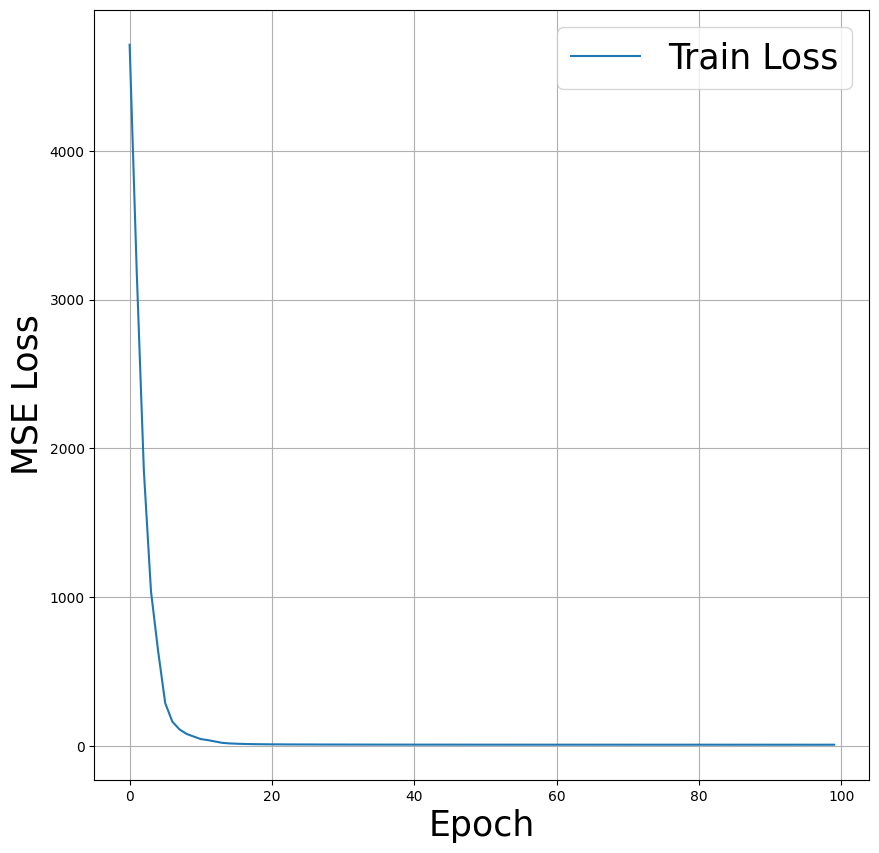

In [28]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.legend(['Train Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.grid()
plt.show()

8


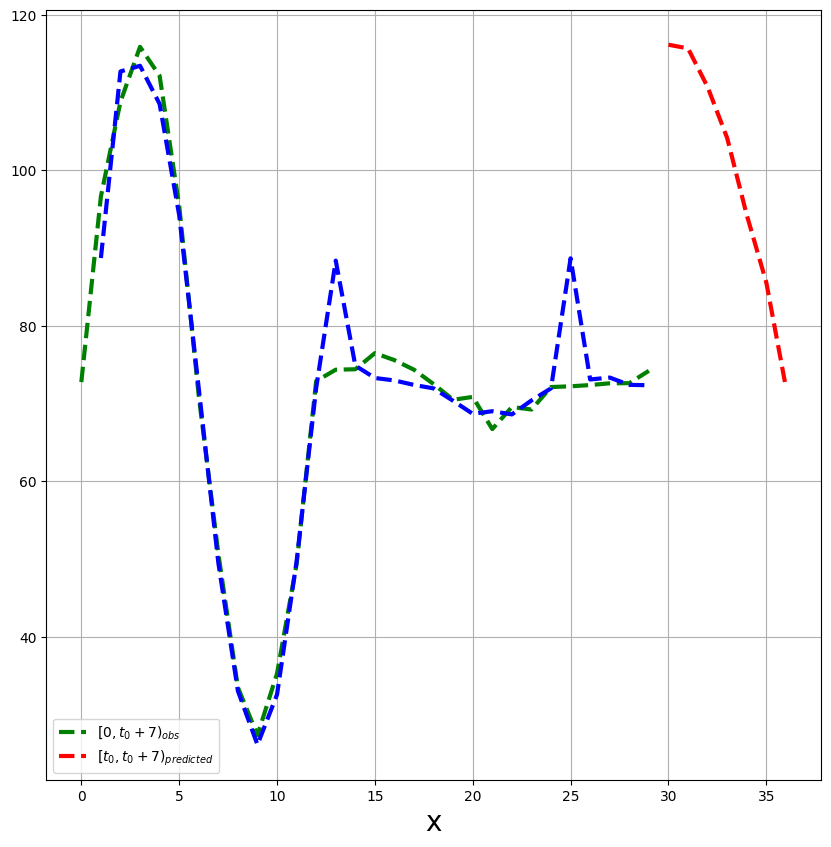

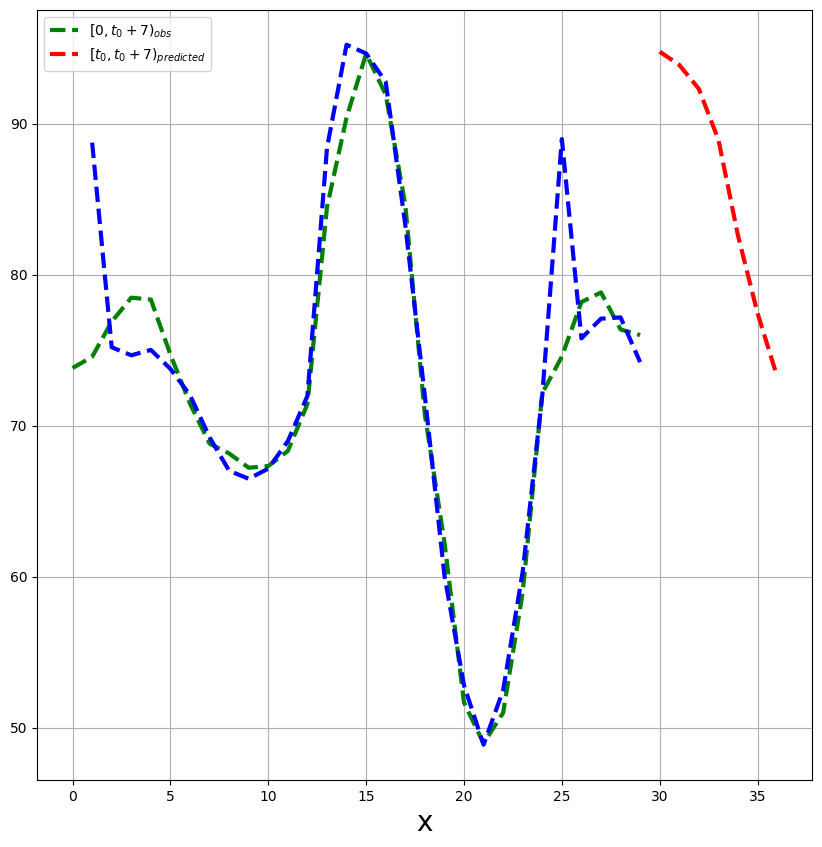

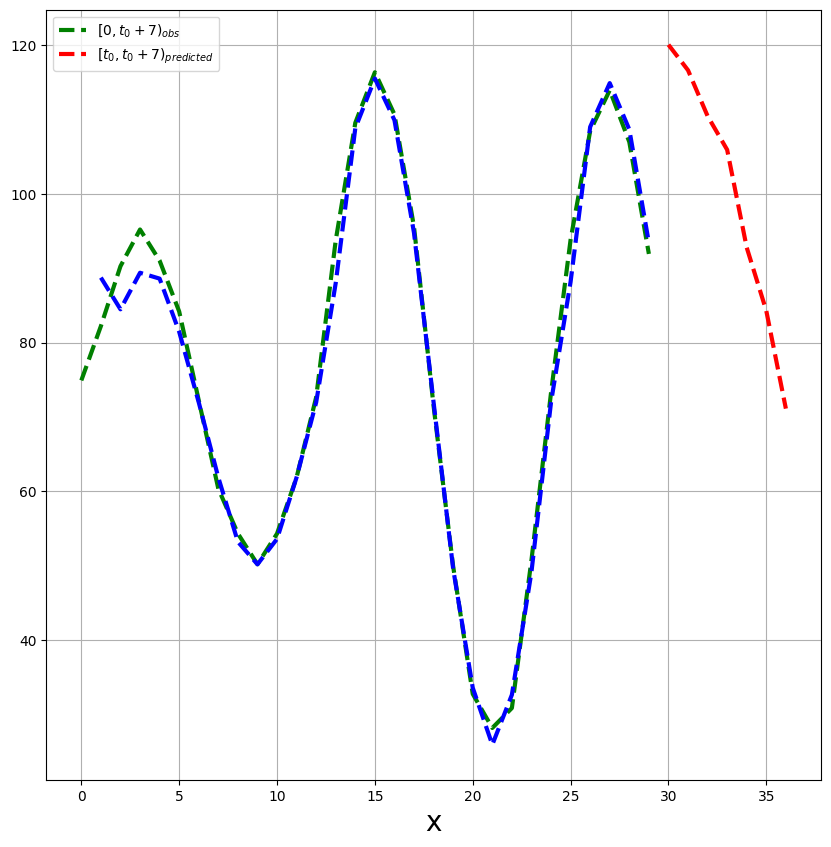

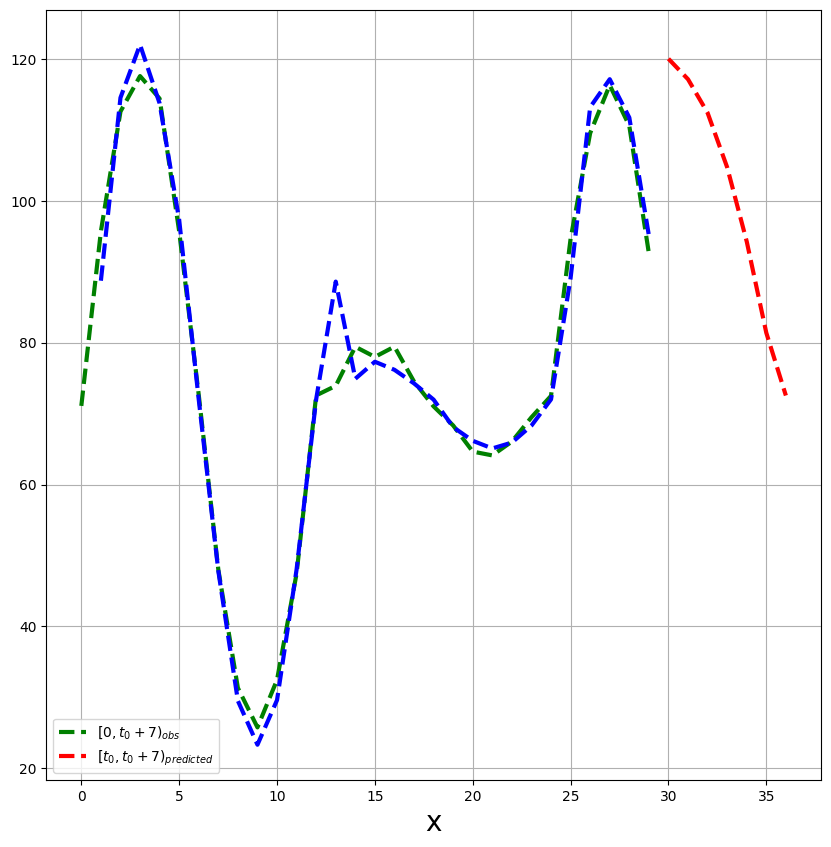

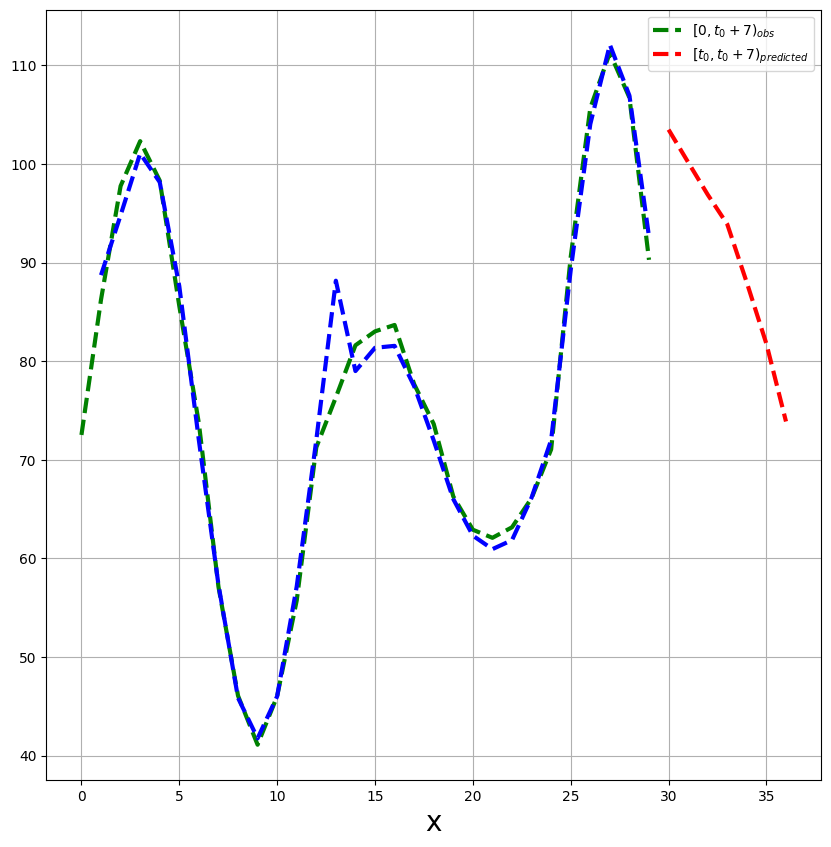

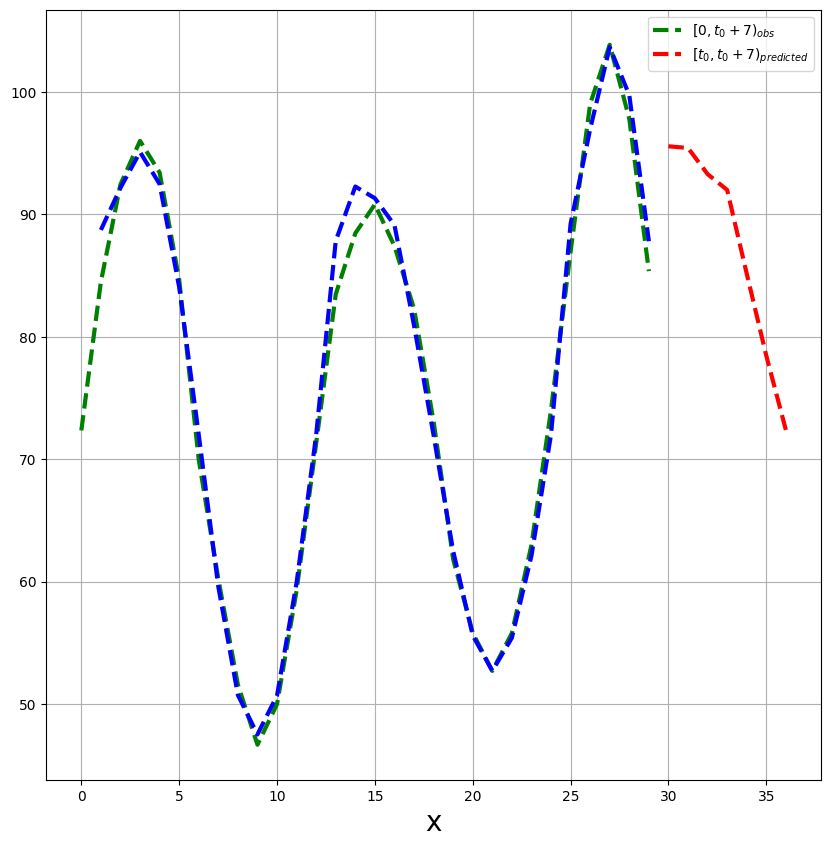

In [30]:
n_plots = 5
with torch.no_grad():
    model.eval()
    print(len(test_dl))
    for step,(x,src, tar) in enumerate(test_dl):
        src_in = src[:,:-1]
        src_out = src[:,1:]
        output = model(x[:,:-1].cuda().float(),src_in.cuda().float())
        # x[batch, seq_len]
        # y[batch, seq_len]
        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            plt.plot(x[0],src[0].numpy(),'g--',linewidth=3)
            plt.plot(np.arange(train_length, train_length+forcast_window),tar[0], 'r--' ,linewidth=3)
            plt.plot(np.arange(1, train_length),output[0,:].cpu().detach().squeeze(-1).numpy(),'b--',linewidth=3) # not missing data
            # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+{7})_{obs}$","$[t_0,t_0+{7})_{predicted}$"])
            plt.grid()
            plt.show()

8


F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


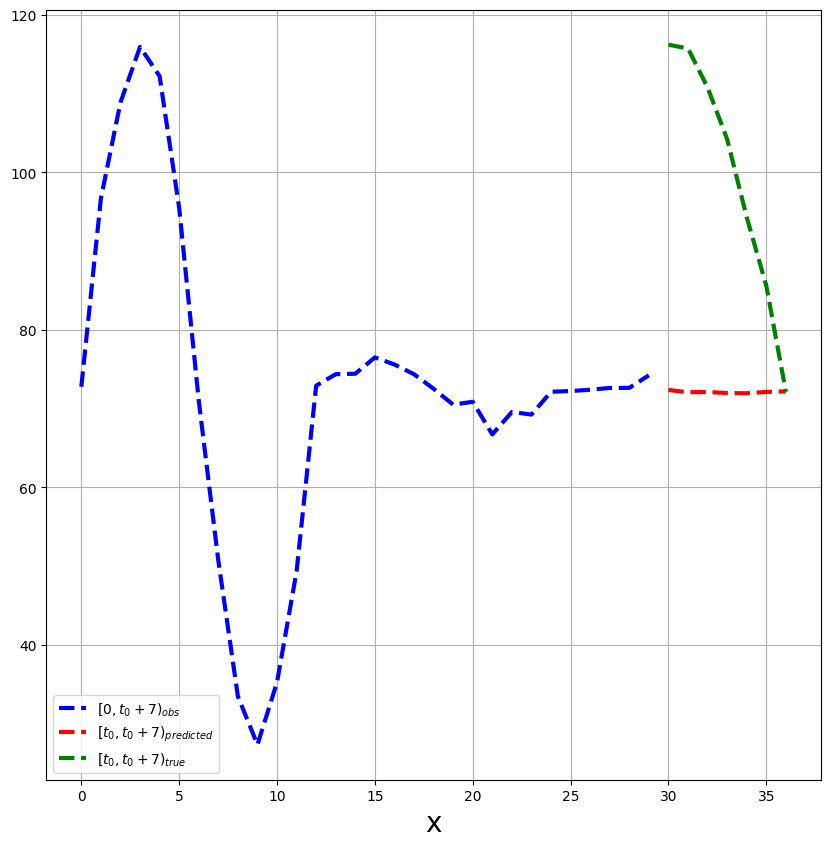

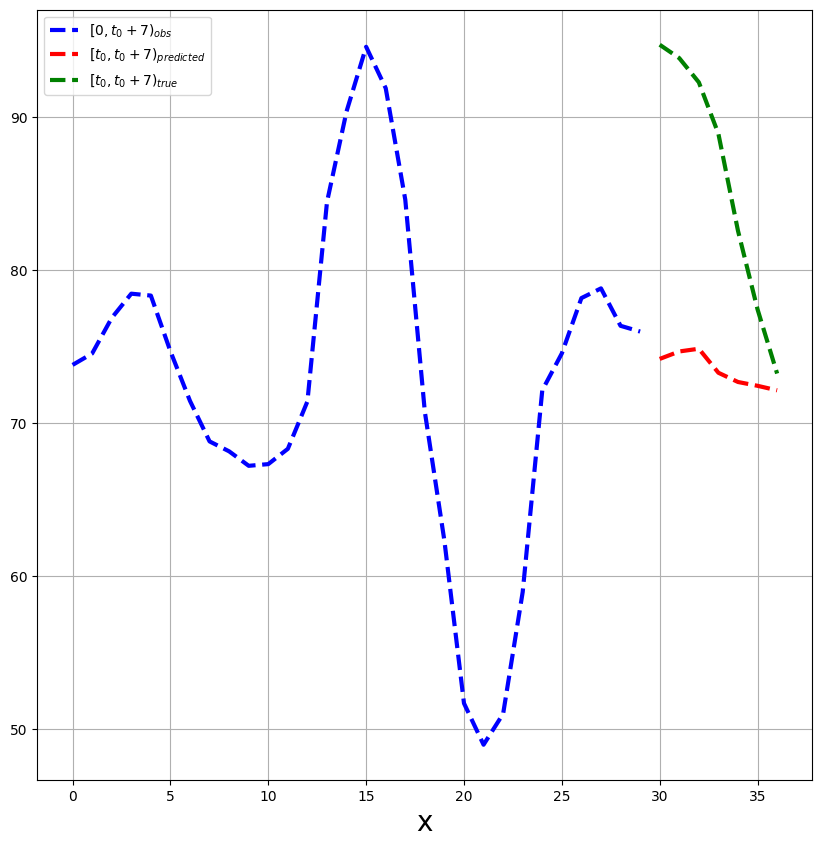

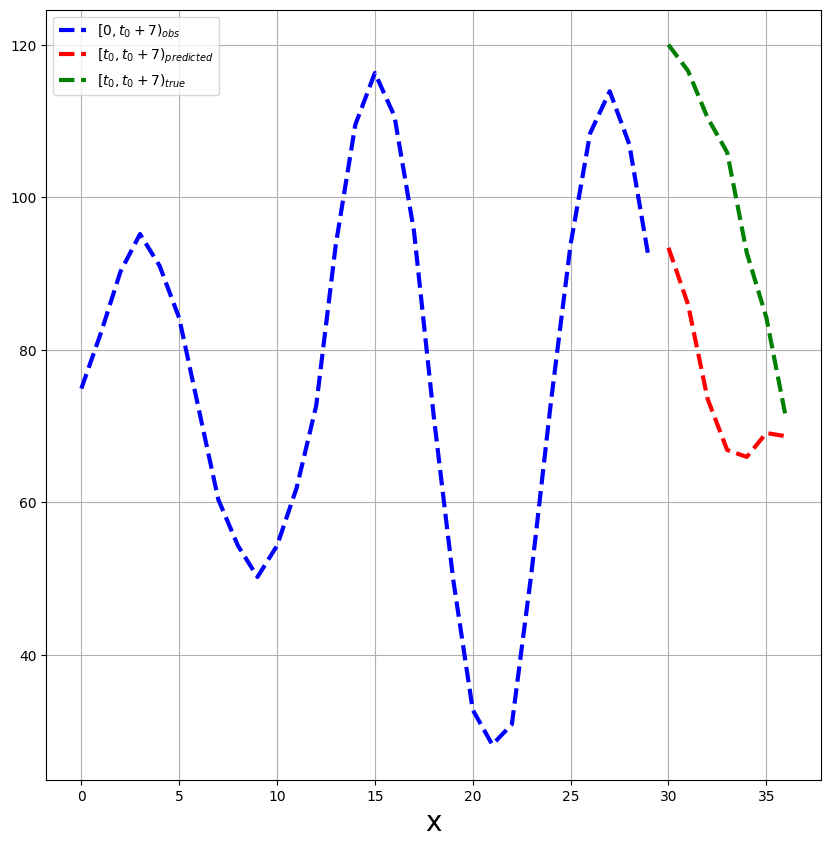

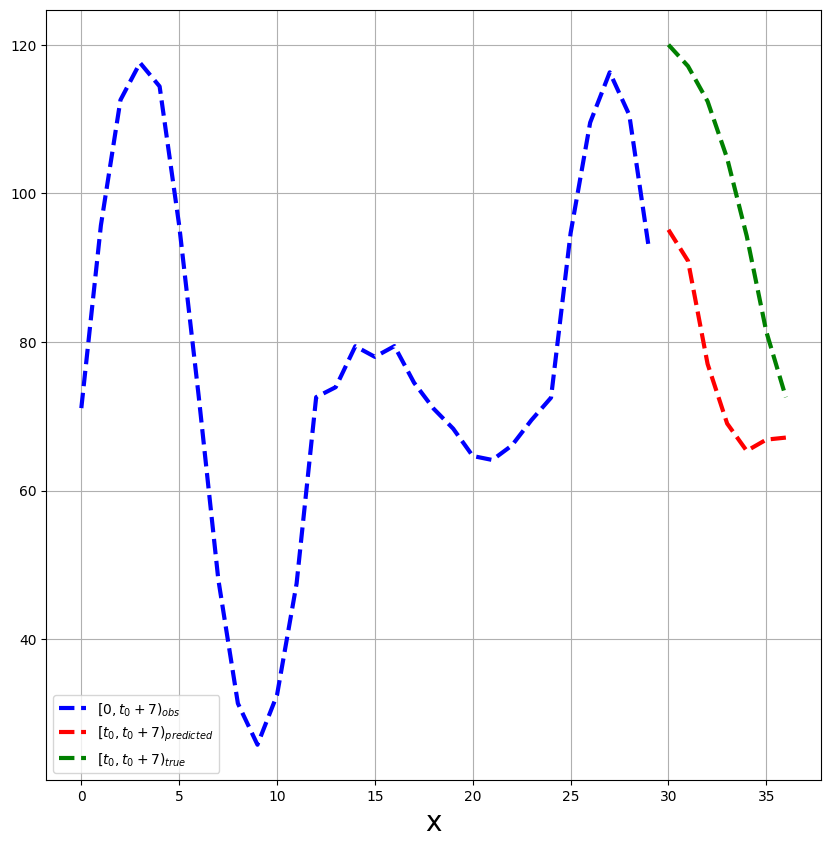

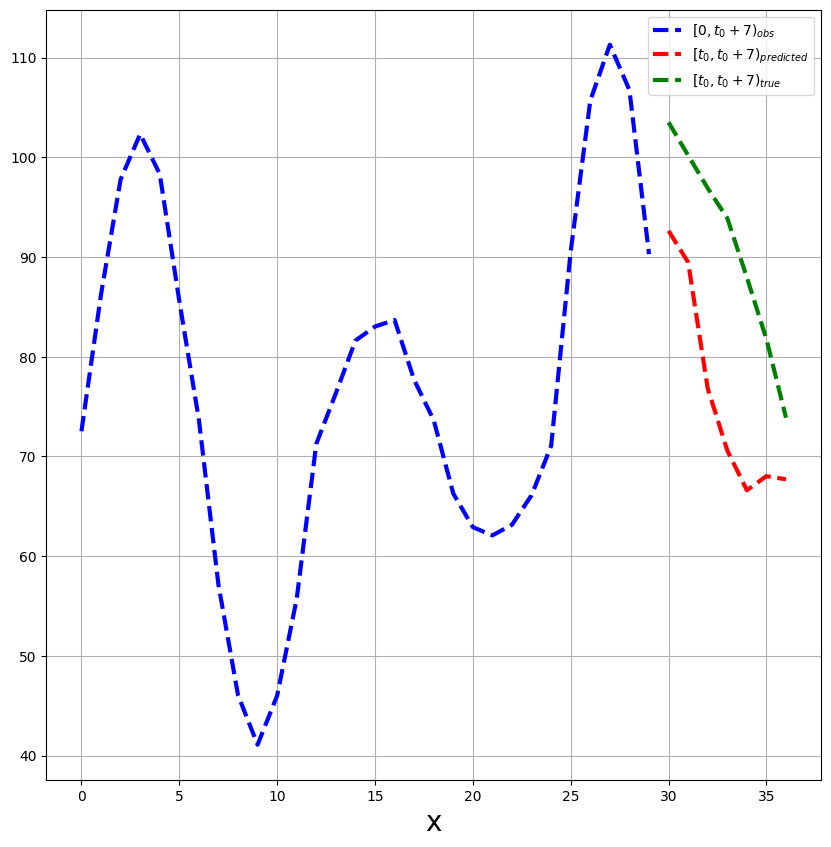

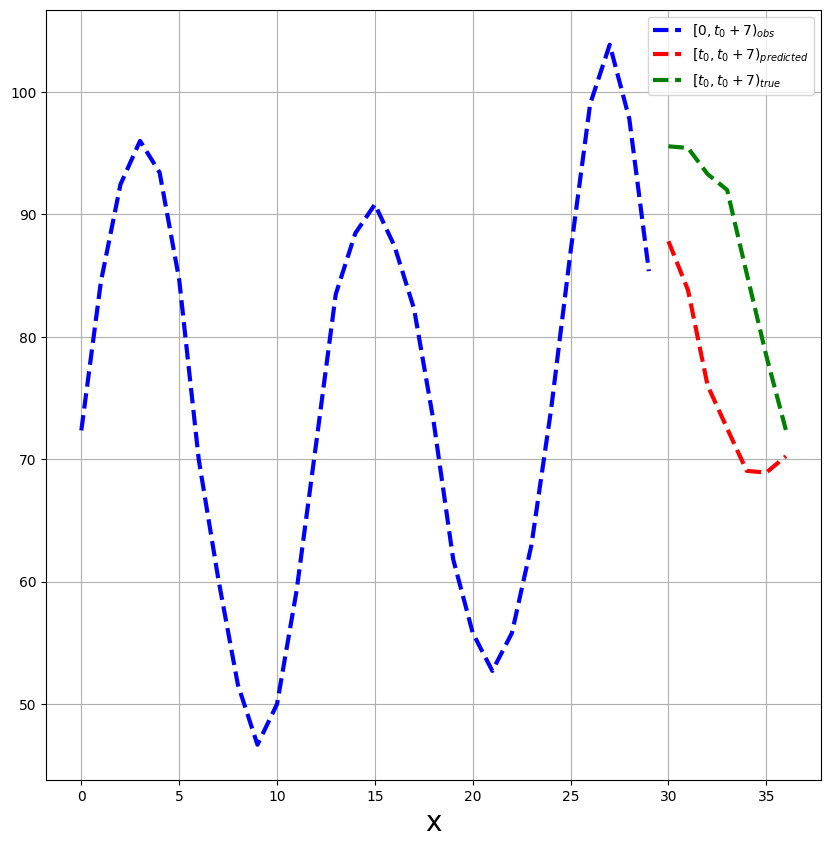

In [32]:
n_plots = 5
with torch.no_grad():
    model.eval()
    print(len(test_dl))
    for step,(x,src, tar) in enumerate(test_dl):
        src_in = src[:,:-1]
        src_out = src[:,1:]
        next_input = src_in
        all_predictions = []
        for i in range(forcast_window):
            output = model(x[:,:-1].cuda().float(),next_input.cuda().float())
            if all_predictions==[]:
                all_predictions = output[:,-1]
            else:
                all_predictions = torch.cat((all_predictions, output[:,-1].detach()),dim=-1)
            next_input = torch.cat((next_input[:,1:].cuda(), output[:,-1]), dim=-1)
        # x[batch, seq_len]
        # y[batch, seq_len]
        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            plt.plot(x[0].cpu().detach().squeeze().numpy(),src[0].cpu().detach().squeeze().numpy(),'b--',linewidth=3)
            # plt.plot(x[0]+forcast_window,tar[0].cpu().detach().numpy(),'g--',linewidth=3)
            plt.plot(np.arange(train_length,train_length+forcast_window),all_predictions[0,:].cpu().detach().numpy(),'r--',linewidth=3)
            plt.plot(np.arange(train_length,train_length+forcast_window),
                     tar[0], 'g--', linewidth=3)# not missing data
            # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+{7})_{obs}$","$[t_0,t_0+{7})_{predicted}$","$[t_0,t_0+{7})_{true}$"])
            plt.grid()
            plt.show()